# Тестовое задание

Есть датасет https://yadi.sk/i/e9ez3rAP1wxHHw сообщений. 1 означает, что сообщение "хорошеe", 0 что плохое. Нужно:

1. Построить классификатор (подобрать модель и признаки), на выходе jupyter notebook
2. Обернуть решение в API с одним эндпоинтом в Докер со спекой {text: } и возвращает {class: }. АПИ пишем в production-ready стиле

По времени около 2х часов максимум. Можно (и нужно) использовать любые открытые решения (главное понимать и умееть объяснить).

## Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import re

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Scoring
from sklearn.metrics import accuracy_score, f1_score

import seaborn as sns

import multiprocessing


from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

%matplotlib inline

## Загрузка данных

In [2]:
data = pd.read_csv('data/dataset_for_assignment.csv')

## Анализ данных

In [3]:
# Распредение признаков
data.groupby('target').count()

,comment_text
target,
0,143346
1,16225


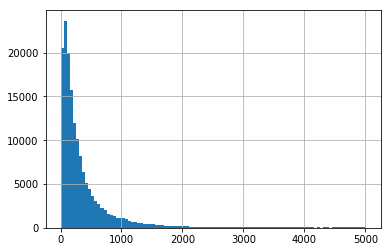

In [4]:
# Распределение текстов по количеству символов
data.comment_text.str.len().hist(bins=100)

In [5]:
# Три варианта "хороших" комментариев
for i, text in data[data.target==1].head(3).iterrows():
    print("Good comment: \n {0} \n".format(text['comment_text']))

Good comment: 
 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK 

Good comment: 
 Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings... 

Good comment: 
 Bye! 

Don't look, come or think of comming back! Tosser. 



In [6]:
# Три варианта "плохих" комментариев
for i, text in data[data.target!=1].head(3).iterrows():
    print("Bad comment: \n {0} \n".format(text['comment_text']))

Bad comment: 
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27 

Bad comment: 
 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC) 

Bad comment: 
 Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info. 



### Токенизация и очистка данных

Сделаем токенизацию слов из текстов

In [31]:
mystopwords = stopwords.words('english') + ["i'm", '-', "i've"]
regex = re.compile("['A-Za-z\-]+")

def tokenize(text, regex=regex, stopwords=mystopwords):
    """ Tokenize all tokens from text string
        Returns array of tokens
    """
    try:
        text = " ".join(regex.findall(text)).lower()
        tokens = ' '.join([token for token in text.split(' ') if not token in stopwords])
        return tokens
    except:
        return []

In [32]:
data['text'] = data.comment_text.apply(tokenize)

In [35]:
data.head()

,comment_text,target,text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,d'aww matches background colour seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,can't make real suggestions improvement wonder...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page that's


### Определим частоту слов построим облако слов для того чтобы понять о чем большинство текстов

In [36]:
from collections import Counter

lemmata = []
for index, row in data.iterrows():
    lemmata += row['text'].split()
cnt = Counter(lemmata)

for i in cnt.most_common(15):
    print(i)

('article', 55933)
('page', 45996)
('wikipedia', 45772)
('talk', 37540)
('please', 29782)
('would', 29232)
('one', 28232)
('like', 27763)
('see', 21550)
('also', 20619)
('think', 20063)
('know', 19036)
('people', 17870)
('edit', 17784)
('articles', 16719)


In [ ]:
# Количество слов в словаре:
print(len(cnt).format('')

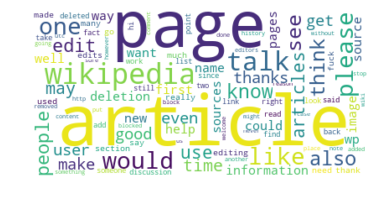

In [37]:
from wordcloud import *
word_freq = [i for i in cnt.most_common(100)]
wd = WordCloud(background_color = 'white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Сформируем сбалансированный датасет c обучающей и тестовой выборкой
Поскольку датасет несбалансирован, применим Undersampling подход

In [38]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

X = data[['text']]
y = data['target']

X_balanced, y_balanced = rus.fit_resample(X, y)

In [39]:
balanced = pd.DataFrame.from_dict({'text': X_balanced[:,0], 'target': y_balanced}) 
balanced.head()

,text,target
0,understand sentence several authors criticised...,0
1,thanks really mind attacks neighbor small yapp...,0
2,october utc spinout article therefore violatio...,0
3,formula one season,0
4,welcome hello wikipedia one thousands editors ...,0


In [40]:
# Сделаем обучающую и тестовую выборку
train, test = train_test_split(balanced, test_size=0.2, random_state=42)

### Построим векторную модель с помощью Doc2Vec

In [41]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [42]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['text'].split(' '), tags=[r.target]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['text'].split(' '), tags=[r.target]), axis=1)

In [43]:
train_tagged.values[30]

TaggedDocument(words=['fucking', 'retarded', 'nigger'], tags=[1])

In [51]:
model_dbow = Doc2Vec(dm=0, vector_size=2000, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 25960/25960 [00:00<00:00, 1313914.95it/s]


In [52]:
# Обучаем модель
for epoch in range(10):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 25960/25960 [00:00<00:00, 2473796.02it/s]


In [53]:
# Сформируем итоговый набор векторов для обучения
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [54]:
## Логистическая регрессия

In [55]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [56]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [57]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.8808936825885978
Testing F1 score: 0.8808858515324212


## Сохраним модель для отправки в Docker

Какие данные нужны для того чтобы сделать вычисления:
   1. Список стоп-слов
   2. Модель Doc2Vec
   3. Итоговая модель логистической регрессии

In [58]:
# Save Model Using Pickle
import pickle

# Названия файлов для сохранения параметров
filename_stopwords = 'docker/api/models/stopwords.txt'
filename_doc2vec = 'docker/api/models/doc2vec'
filename_model = 'docker/api/models/model.pkl'

with open(filename_stopwords, 'wb') as fid:
    pickle.dump(mystopwords, fid)
    
with open(filename_doc2vec, 'wb') as fid:
    model_dbow.save(fid) 
    
with open(filename_model, 'wb') as fid:
    pickle.dump(logreg, fid)   
 

### Тестирование запущенного docker-контейнера

In [357]:
import requests

url = 'http://0.0.0.0:8000/predict'    
request_data = {"text": "fuck you STAS i hate you"}
res = requests.post(url, json=request_data)    
print(res.json())

{'class': '1'}
